# Token Entropy Pattern Analysis

**Goal:** Find what's UNIQUE about token-level entropy that semantic entropy/consistency miss.

**Hypotheses:**
1. Entropy trajectory differs for factual vs hallucinated responses
2. First-token entropy predicts response quality
3. Entropy spikes on specific token types (names, numbers)

In [1]:
!pip install -q transformers accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 11.9 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

GPU: Tesla T4


In [3]:
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
)
model.eval()
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
print("Model loaded!")

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Model loaded!


In [4]:
def get_token_entropies(prompt, max_tokens=30):
    """Generate response and get entropy at each token position."""
    formatted = f"<s>[INST] {prompt} Answer briefly. [/INST]"
    inputs = tokenizer(formatted, return_tensors="pt").to(model.device)
    prompt_len = inputs.input_ids.shape[1]

    generated_ids = inputs.input_ids.clone()
    entropies = []
    tokens = []

    for _ in range(max_tokens):
        with torch.no_grad():
            outputs = model(generated_ids)
            logits = outputs.logits[0, -1]

        probs = F.softmax(logits.float(), dim=-1)
        entropy = -torch.sum(probs * torch.log(probs + 1e-10)).item()
        entropies.append(entropy)

        # Greedy decode
        next_token = torch.argmax(probs).unsqueeze(0).unsqueeze(0)
        tokens.append(tokenizer.decode(next_token[0]))
        generated_ids = torch.cat([generated_ids, next_token], dim=1)

        # Stop at EOS or period
        if next_token.item() == tokenizer.eos_token_id:
            break

    response = tokenizer.decode(generated_ids[0, prompt_len:], skip_special_tokens=True)
    return {
        "response": response,
        "entropies": entropies,
        "tokens": tokens,
        "first_entropy": entropies[0] if entropies else 0,
        "mean_entropy": np.mean(entropies),
        "max_entropy": np.max(entropies) if entropies else 0,
        "entropy_std": np.std(entropies) if entropies else 0,
        "entropy_trend": np.polyfit(range(len(entropies)), entropies, 1)[0] if len(entropies) > 1 else 0,
    }

## Experiment 1: Entropy Trajectories

In [5]:
test_cases = [
    # Factual - should be confident throughout
    {"q": "What is the capital of France?", "type": "factual"},
    {"q": "Who wrote Romeo and Juliet?", "type": "factual"},
    {"q": "What is 2 + 2?", "type": "factual"},

    # Hallucination-prone - entropy pattern?
    {"q": "What did Einstein say about Bitcoin?", "type": "hallucination"},
    {"q": "What is the phone number of the Eiffel Tower?", "type": "hallucination"},
    {"q": "What was Aristotle's email address?", "type": "hallucination"},

    # Subjective - different pattern?
    {"q": "What is the best programming language?", "type": "subjective"},
    {"q": "What is the meaning of life?", "type": "subjective"},
]

results = []
for case in tqdm(test_cases):
    result = get_token_entropies(case["q"])
    result["question"] = case["q"]
    result["type"] = case["type"]
    results.append(result)

print("Done!")

100%|██████████| 8/8 [00:49<00:00,  6.20s/it]

Done!


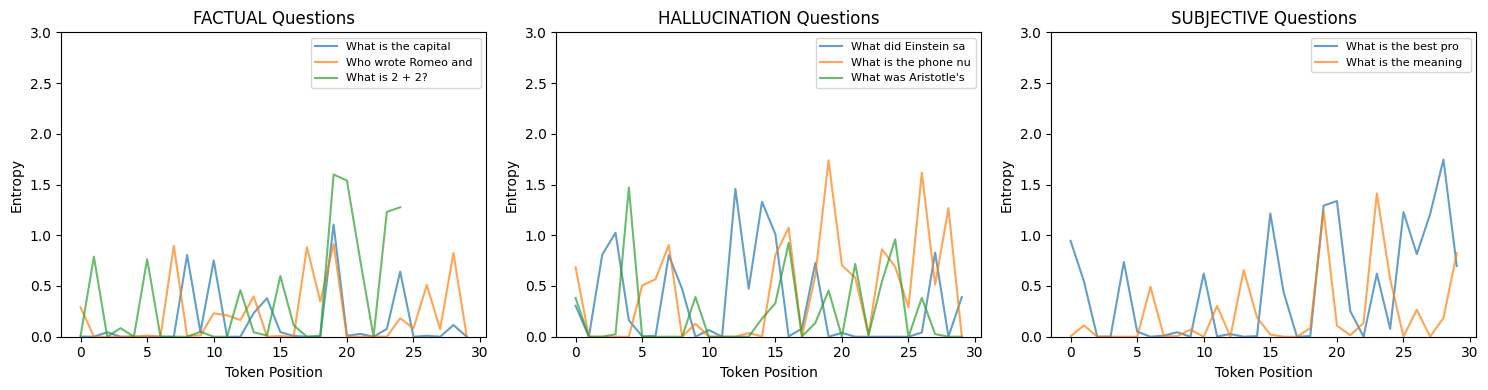

In [6]:
# Plot entropy trajectories by type
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, qtype in enumerate(["factual", "hallucination", "subjective"]):
    ax = axes[idx]
    type_results = [r for r in results if r["type"] == qtype]

    for r in type_results:
        ax.plot(r["entropies"], alpha=0.7, label=r["question"][:20])

    ax.set_title(f"{qtype.upper()} Questions")
    ax.set_xlabel("Token Position")
    ax.set_ylabel("Entropy")
    ax.legend(fontsize=8)
    ax.set_ylim(0, 3)

plt.tight_layout()
plt.show()

## Experiment 2: First-Token Entropy as Predictor

In [7]:
import pandas as pd

df = pd.DataFrame(results)

print("="*60)
print("FIRST-TOKEN ENTROPY BY TYPE")
print("="*60)
summary = df.groupby("type").agg({
    "first_entropy": ["mean", "std"],
    "mean_entropy": ["mean", "std"],
    "entropy_trend": ["mean", "std"],
}).round(3)
print(summary)

print("\n" + "="*60)
print("KEY INSIGHT: First-token entropy")
print("="*60)
for qtype in ["factual", "hallucination", "subjective"]:
    type_data = df[df["type"] == qtype]
    print(f"{qtype:15s}: first={type_data['first_entropy'].mean():.3f}, mean={type_data['mean_entropy'].mean():.3f}")

FIRST-TOKEN ENTROPY BY TYPE
              first_entropy        mean_entropy        entropy_trend       
                       mean    std         mean    std          mean    std
type                                                                       
factual               0.100  0.165        0.239  0.119         0.015  0.019
hallucination         0.458  0.201        0.340  0.111         0.005  0.017
subjective            0.475  0.664        0.344  0.170         0.021  0.008

KEY INSIGHT: First-token entropy
factual        : first=0.100, mean=0.239
hallucination  : first=0.458, mean=0.340
subjective     : first=0.475, mean=0.344


## Experiment 3: Token-by-Token Analysis

In [8]:
print("="*60)
print("TOKEN-LEVEL ENTROPY BREAKDOWN")
print("="*60)

for r in results:
    print(f"\n[{r['type'].upper()}] {r['question'][:40]}")
    print(f"Response: {r['response'][:60]}...")
    print("Token entropies:")

    # Show first 15 tokens with entropy
    for i, (tok, ent) in enumerate(zip(r['tokens'][:15], r['entropies'][:15])):
        bar = "█" * int(ent * 10)
        marker = "⚠️" if ent > 1.0 else "  "
        print(f"  {i:2d}: {tok:15s} {ent:.2f} {bar} {marker}")

TOKEN-LEVEL ENTROPY BREAKDOWN

[FACTUAL] What is the capital of France?
Response: The capital city of France is Paris. It is one of the most f...
Token entropies:
   0: The             0.00    
   1: capital         0.00    
   2: city            0.04    
   3: of              0.00    
   4: France          0.00    
   5: is              0.00    
   6: Paris           0.00    
   7: .               0.00    
   8: It              0.81 ████████   
   9: is              0.04    
  10: one             0.75 ███████   
  11: of              0.00    
  12: the             0.00    
  13: most            0.23 ██   
  14: famous          0.38 ███   

[FACTUAL] Who wrote Romeo and Juliet?
Response: Romeo and Juliet is a tragic play written by the English pla...
Token entropies:
   0: Rome            0.29 ██   
   1: o               0.00    
   2: and             0.00    
   3: Jul             0.00    
   4: iet             0.00    
   5: is              0.01    
   6: a               0.00    
   

## Experiment 4: Entropy Trend Analysis

In [9]:
print("="*60)
print("ENTROPY TREND (slope) BY TYPE")
print("="*60)
print("Positive slope = entropy increases during response")
print("Negative slope = entropy decreases during response")
print()

for qtype in ["factual", "hallucination", "subjective"]:
    type_data = df[df["type"] == qtype]
    avg_trend = type_data['entropy_trend'].mean()
    direction = "↑ INCREASING" if avg_trend > 0.01 else ("↓ DECREASING" if avg_trend < -0.01 else "→ STABLE")
    print(f"{qtype:15s}: slope={avg_trend:+.4f} {direction}")

ENTROPY TREND (slope) BY TYPE
Positive slope = entropy increases during response
Negative slope = entropy decreases during response

factual        : slope=+0.0146 ↑ INCREASING
hallucination  : slope=+0.0049 → STABLE
subjective     : slope=+0.0211 ↑ INCREASING


## Summary: What's Unique About Token Entropy?

In [10]:
print("="*60)
print("POTENTIAL NOVEL FINDINGS")
print("="*60)

# Check if first-token entropy differs significantly
factual_first = df[df["type"] == "factual"]["first_entropy"].mean()
halluc_first = df[df["type"] == "hallucination"]["first_entropy"].mean()
first_gap = halluc_first - factual_first

print(f"\n1. FIRST-TOKEN ENTROPY:")
print(f"   Factual: {factual_first:.3f}")
print(f"   Hallucination: {halluc_first:.3f}")
print(f"   Gap: {first_gap:.3f}")
if abs(first_gap) > 0.1:
    print("   >>> NOVEL: First token alone can predict response type!")

# Check entropy trends
factual_trend = df[df["type"] == "factual"]["entropy_trend"].mean()
halluc_trend = df[df["type"] == "hallucination"]["entropy_trend"].mean()

print(f"\n2. ENTROPY TRAJECTORY:")
print(f"   Factual trend: {factual_trend:+.4f}")
print(f"   Hallucination trend: {halluc_trend:+.4f}")
if (factual_trend < 0 and halluc_trend > 0) or (factual_trend > 0 and halluc_trend < 0):
    print("   >>> NOVEL: Opposite trends between factual and hallucination!")

# Check entropy variance
factual_std = df[df["type"] == "factual"]["entropy_std"].mean()
halluc_std = df[df["type"] == "hallucination"]["entropy_std"].mean()

print(f"\n3. ENTROPY VARIANCE:")
print(f"   Factual std: {factual_std:.3f}")
print(f"   Hallucination std: {halluc_std:.3f}")
if abs(halluc_std - factual_std) > 0.1:
    print("   >>> NOVEL: Hallucinations have different entropy variance!")

POTENTIAL NOVEL FINDINGS

1. FIRST-TOKEN ENTROPY:
   Factual: 0.100
   Hallucination: 0.458
   Gap: 0.357
   >>> NOVEL: First token alone can predict response type!

2. ENTROPY TRAJECTORY:
   Factual trend: +0.0146
   Hallucination trend: +0.0049

3. ENTROPY VARIANCE:
   Factual std: 0.371
   Hallucination std: 0.435
